## Load Libraries

In [242]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.stattools import adfuller
from mysql.connector import connect, Error
from sqlalchemy import create_engine
import json
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from prophet import Prophet, serialize
from prophet.serialize import model_to_json, model_from_json
from scipy.stats import uniform
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit, GridSearchCV
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
import mlflow
import mlflow.prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
import warnings
warnings.filterwarnings("ignore")

## Load Dataset

In [243]:
def load_dataset():
    try:
        nvda = pd.read_csv('../data/raw/nvda_stock_prices_data(2019-10-05 - 2024-10-05).csv')
        gspc = pd.read_csv('../data/raw/gspc_stock_prices_data(2019-10-05 - 2024-10-05).csv')
        return nvda, gspc
    except Exception as e:
        print(e)
df_nvda, df_gspc = load_dataset()


In [244]:
df_nvda.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-10-07,4.61450,4.7085,4.60575,4.60825,4.585944,480984000
1,2019-10-08,4.51600,4.5160,4.41250,4.43075,4.409303,444436000
2,2019-10-09,4.50800,4.5675,4.47900,4.51775,4.495882,292412000
3,2019-10-10,4.51550,4.6270,4.51025,4.57575,4.553601,309124000
4,2019-10-11,4.66025,4.7335,4.64125,4.64975,4.627243,446404000


In [245]:
df_gspc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-10-07,2944.229980,2959.750000,2935.679932,2938.790039,2938.790039,2959050000
1,2019-10-08,2920.399902,2925.469971,2892.659912,2893.060059,2893.060059,3370700000
2,2019-10-09,2911.100098,2929.320068,2907.409912,2919.399902,2919.399902,2735350000
3,2019-10-10,2918.550049,2948.459961,2917.120117,2938.129883,2938.129883,3234400000
4,2019-10-11,2963.070068,2993.280029,2963.070068,2970.270020,2970.270020,3581320000


In [246]:
df_nvda.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-10-07,4.61450,4.7085,4.60575,4.60825,4.585944,480984000
1,2019-10-08,4.51600,4.5160,4.41250,4.43075,4.409303,444436000
2,2019-10-09,4.50800,4.5675,4.47900,4.51775,4.495882,292412000
3,2019-10-10,4.51550,4.6270,4.51025,4.57575,4.553601,309124000
4,2019-10-11,4.66025,4.7335,4.64125,4.64975,4.627243,446404000


## Exploratory Data Analysis (EDA) with Early Preprocessing

In [247]:
df_nvda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Close      1258 non-null   float64
 5   Adj Close  1258 non-null   float64
 6   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [248]:
df_gspc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Close      1258 non-null   float64
 5   Adj Close  1258 non-null   float64
 6   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [249]:
def early_preprocess_dataset(df):
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ', '_')
    df['date'] = pd.to_datetime(df['date'])
    return df
df_nvda = early_preprocess_dataset(df_nvda)
df_gspc = early_preprocess_dataset(df_gspc)

## NVIDIA and GSPC Trend Visualization

In [250]:
def stock_plot_history(df,title): 
    fig = go.Figure()
    columns = ['close', 'adj_close']
    for col in columns:
      fig.add_trace(go.Scatter(
        x = df['date'],
        y = df[col],
        mode = 'lines',
        name = col.capitalize() + ' Price')) 
    
    fig.update_layout(
    title = title,
    width=1500, height=400,
    xaxis_title = 'Date',
    yaxis_title = 'Price')
    fig.show()

# def gspc_stock_plot(df): 
#     fig = go.Figure()
#     columns = ['close', 'adj_close']
#     for col in columns:
#       fig.add_trace(go.Scatter(
#         x = df['date'],
#         y = df[col],
#         mode = 'lines',
#         name = col.capitalize() + ' Price')) 
    
#     fig.update_layout(
#     title = ,
#     xaxis_title = 'Date',
#     yaxis_title = 'Price')
#     fig.show()

stock_plot_history(df_nvda,"Close Price and Adjusted Close Price of NVIDIA (NVDA) Stock")
stock_plot_history(df_gspc,"Close Price and Adjusted Close Price of S&P 500 (GSPC) Index")

`Nvidia Stock Data Analysis:`
* Over the last five years, NVIDIA stock prices (Close and Adj Close) have shown a positive trend. After the COVID-19 pandemic (around 2022), the prices began to increase significantly.
* This comparison between Close and Adj Close indicates that there are no significant differences between the two prices, meaning it is acceptable to choose either the Close or Adj Close price.
* At a glance, this data exhibits a pattern (is non-stationary), but to confirm and reject this hypothesis, we will conduct the Augmented Dickey-Fuller Test, as referenced here: (https://www.statology.org/dickey-fuller-test-python/).
    * H0: The time series is non-stationary (has a pattern).
    * H1: The time series is stationary (has no pattern).
* If a p-value > 0.05: H0 fails t
o be rejected
* If a p-value < 0.05: H0 rejected.

`S&P 500 (GSPC) Stock Data Analysis:`
* S&P 500 (GSPC) is a market that tracks large companies listed on US stock exchanges, including NVIDIA (NVDA).
* I will use this index as additional variable, serving as an external factor in the model to improve the prediction NVIDIA's stock prices in the future by capturing broader market trends that reflected in S&P 500.

### Testing for Stationarity Using the Augmented Dickey-Fuller Test

In [251]:
# Generate the ADF test and get p-value
def adf_test(df):
    p_value = adfuller(df['close'])[1]
    if p_value > 0.05:
        print(f'p_value: {p_value}')
        print('H0 failes to be rejected. The time series is not stationary (has a trend or pattern)')
    else:
        print(f'p_value: {p_value}')
        print('H0  rejected. The time series is stationary (has no pattern)')

adf_test(df_nvda)

p_value: 0.9975276111259581
H0 failes to be rejected. The time series is not stationary (has a trend or pattern)


* Augmented Dickey-Fuller (ADF) test show a result that the Close Price at this range time is non stationary
* This result also help us to use certain models that can handle non statsionary data

## Preprocessing

### Provide only date and close price columns for nvidia stock price and GSPC market index

In [252]:
def preprocess_dataset(df):
    df = df[['date', 'close']]
    df = df.rename(columns = {'date': 'ds', 'close': 'y'})
    df['ds'] = pd.to_datetime(df['ds'])
    return df

df_nvda = preprocess_dataset(df_nvda)
df_gspc = preprocess_dataset(df_gspc)

### Merge NVIDIA and GSPC dataframe and split into Train and Test Dataframe

In [253]:
def merge_dataset(df_nvda, df_gspc):
    # date_threshold = '2023-12-31'
    # date_threshold = '2024-03-31'
    date_threshold = '2024-07-31'
    df = pd.merge(df_nvda,df_gspc[['ds','y']],on = 'ds', how = 'left', suffixes = ('','_gspc'))
    df_train = df[df['ds'] <= date_threshold]
    df_test = df[df['ds'] > date_threshold]
    return df_train, df_test

df_train, df_test = merge_dataset(df_nvda,df_gspc)

### Check Distribution of the Data

In [254]:
# fig, ax = plt.subplots(1, 2, figsize = (20, 5))
# sns.histplot(df_train, x = 'y', kde = True, ax = ax[0])
# ax[0].set_title('NVDIA Stock Close Price Distribution')
# ax[0].set_xlabel('Close Price')
# sns.histplot(df_train, x = 'y_gspc', kde = True, ax = ax[1])
# ax[1].set_title('S&P 500 Index Close Price Distribution')
# ax[1].set_xlabel('Close Price')

# plt.show()
    

The histogram plot above shows that both y (NVIDIA stock close price) and y_gspc (GSPC market index close price) are skewed. This observation suggests that applying a normalization technique to this dataset could improve model performance by addressing the skewness in the data.

### Normalization

In [255]:
# def normalize_dataset(df_train, df_test):
#     scaler = MinMaxScaler()
#     df_train_scaled = df_train[['ds']].copy()
#     df_test_scaled = df_test[['ds']].copy()
#     df_train_scaled[['y','y_gspc']] = scaler.fit_transform(df_train[['y','y_gspc']])
#     df_test_scaled[['y','y_gspc']] = scaler.transform(df_test[['y','y_gspc']])
#     return df_train_scaled, df_test_scaled,scaler

# df_train_scaled, df_test_scaled,scaler = normalize_dataset(df_train, df_test)

## Modeling
Based on the results of the ADF test, we have determined that the dataset for NVIDIA's close price exhibits a non-stationary pattern. Therefore, I will use Facebook Prophet as my primary model to forecast NVIDIA's stock price.


### Base Model

13:07:11 - cmdstanpy - INFO - Chain [1] start processing
13:07:12 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Squared Error (RMSE) Score (Base Model): 13.59


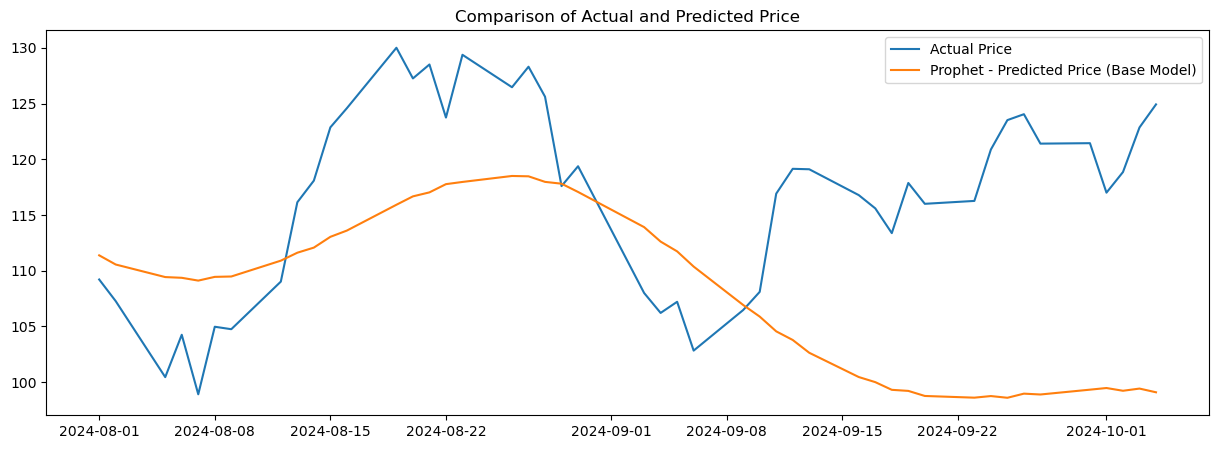

In [256]:
prophet_model = Prophet(seasonality_mode='multiplicative')
future = df_test[['ds']].copy()
prophet_model.fit(df_train)
df_predicted = prophet_model.predict(future)

plt.figure(figsize=(15,5))
plt.plot(df_test['ds'], df_test['y'], label = 'Actual Price')
plt.title('Comparison of Actual and Predicted Price')
plt.plot(df_predicted['ds'],df_predicted['yhat'], label = 'Prophet - Predicted Price (Base Model)')
plt.legend()

rmse = root_mean_squared_error(df_test['y'], df_predicted['yhat'])
print(f'Root Mean Squared Error (RMSE) Score (Base Model): {rmse:.2f}')

### Add Regressor

13:07:12 - cmdstanpy - INFO - Chain [1] start processing
13:07:13 - cmdstanpy - INFO - Chain [1] done processing


RMESE Score (Base): 13.59
RMSE Score (with Regressor): 5.52


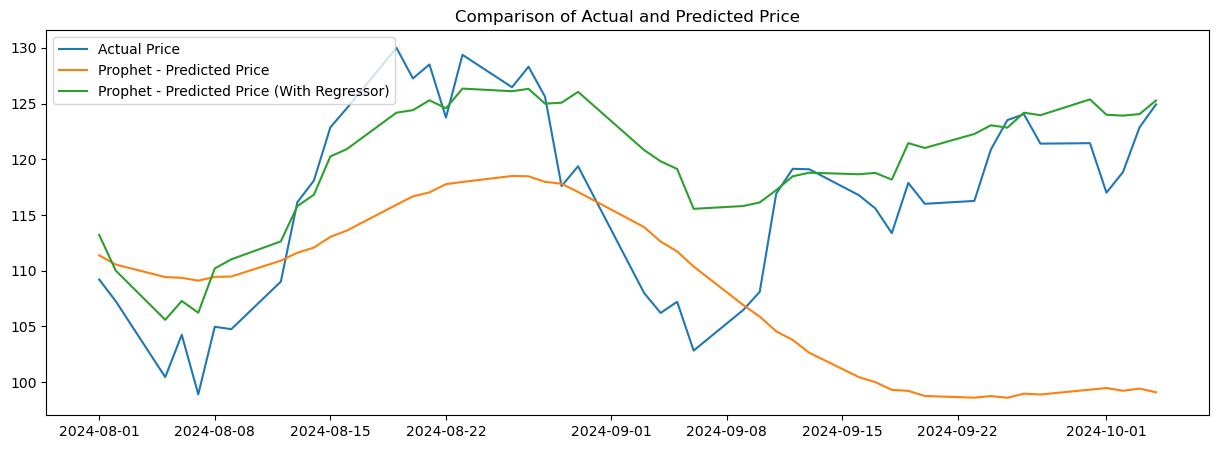

In [257]:
prophet_model_regressor = Prophet(seasonality_mode='multiplicative').add_regressor('y_gspc')
future['y_gspc'] = df_test['y_gspc']
prophet_model_regressor.fit(df_train)
df_predicted_regressor = prophet_model_regressor.predict(future)

plt.figure(figsize=(15,5))
plt.plot(df_test['ds'], df_test['y'], label = 'Actual Price')
plt.plot(df_predicted['ds'],df_predicted['yhat'], label = 'Prophet - Predicted Price')
plt.plot(df_predicted_regressor['ds'],df_predicted_regressor['yhat'], label = 'Prophet - Predicted Price (With Regressor)')
plt.title('Comparison of Actual and Predicted Price')
plt.plot(type = 'scatter')
plt.legend()

rmse_regressor = root_mean_squared_error(df_test['y'], df_predicted_regressor['yhat'])

print(f'RMESE Score (Base): {rmse:.2f}')
print(f'RMSE Score (with Regressor): {rmse_regressor:.2f}')

In [258]:
asd

NameError: name 'asd' is not defined

## Cross Validaton

## Hyperparameter Tuning

In [ ]:
import itertools
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode' : ["multiplicative"],
    'holidays_prior_scale': [0.01, 1.0, 3.0, 10],
    'interval_width': [0.8, 0.9, 0.95],
    'yearly_seasonality' : [True, False],
    'weekly_seasonality' : [True, False],
    'daily_seasonality' : [True, False]
}
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
best_rmse = float('inf')
best_params = None

# Use cross validation to evaluate all parameters
for params in all_params:
   model_opt = Prophet(**params).add_regressor('y_gspc').fit(df_train_scaled)
   future = df_test_scaled[['ds','y_gspc']].copy()
   df_predicted_opt = model_opt.predict(future)[['ds','yhat']]
   rmse = mean_absolute_error(df_test_scaled['y'], df_predicted_opt['yhat'])
   if rmse < best_rmse:
    best_rmse = rmse
    best_params = params

print('Best Parameters:', best_params)
print('Best RMSE Scroe:', best_rmse)

09:56:24 - cmdstanpy - INFO - Chain [1] start processing
09:56:24 - cmdstanpy - INFO - Chain [1] done processing
09:56:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:56:24 - cmdstanpy - INFO - Chain [1] start processing
09:56:28 - cmdstanpy - INFO - Chain [1] done processing
09:56:29 - cmdstanpy - INFO - Chain [1] start processing
09:56:29 - cmdstanpy - INFO - Chain [1] done processing
09:56:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:56:29 - cmdstanpy - INFO - Chain [1] start processing
09:56:34 - cmdstanpy - INFO - Chain [1] done processing
09:56:34 - cmdstanpy - INFO - Chain [1] start processing
09:56:34 - cmdstanpy - INFO - Chain [1] done processing
09:56:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

Best Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10, 'interval_width': 0.8, 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
Best RMSE Scroe: 5.280007744525607


In [ ]:
best_params

{'changepoint_prior_scale': 0.1,
 'seasonality_prior_scale': 10.0,
 'seasonality_mode': 'multiplicative',
 'holidays_prior_scale': 10,
 'interval_width': 0.8,
 'yearly_seasonality': True,
 'weekly_seasonality': True,
 'daily_seasonality': False}

In [ ]:
# with open('best_params.json', 'w') as f:
#     json.dump(best_params, f)

10:51:46 - cmdstanpy - INFO - Chain [1] start processing
10:51:47 - cmdstanpy - INFO - Chain [1] done processing


RMESE Score (Base): 12.71
RMSE Score (Opt with Regressor): 6.89
RMSE Score(Regressor with Hyper Parameter Tuning: 6.75


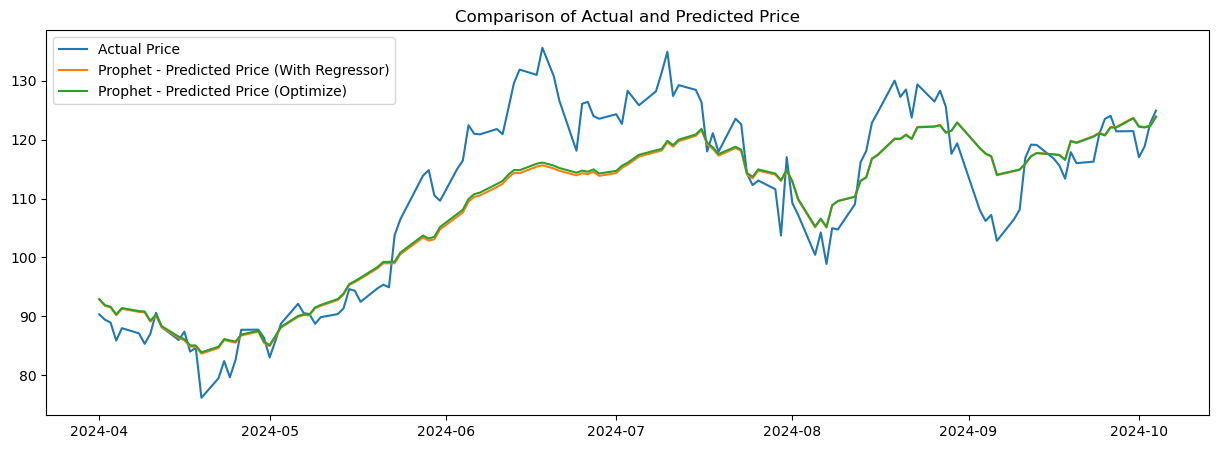

In [ ]:
m_opt = Prophet(**best_params).add_regressor('y_gspc').fit(df_train_scaled)
df_predicted_opt = m_opt.predict(future)
plt.figure(figsize=(15,5))
plt.plot(df_test_scaled['ds'], df_test_scaled['y'], label = 'Actual Price')
plt.plot(df_predicted_regressor['ds'],df_predicted_regressor['yhat'], label = 'Prophet - Predicted Price (With Regressor)')
plt.plot(df_predicted_opt['ds'],df_predicted_opt['yhat'], label = 'Prophet - Predicted Price (Optimize)')
plt.title('Comparison of Actual and Predicted Price')
plt.legend()

rmse_opt = root_mean_squared_error(df_test_scaled['y'], df_predicted_opt['yhat'])
print(f'RMESE Score (Base): {rmse:.2f}')
print(f'RMSE Score (Opt with Regressor): {rmse_regressor:.2f}')
print(f'RMSE Score(Regressor with Hyper Parameter Tuning: {rmse_opt:.2f}')




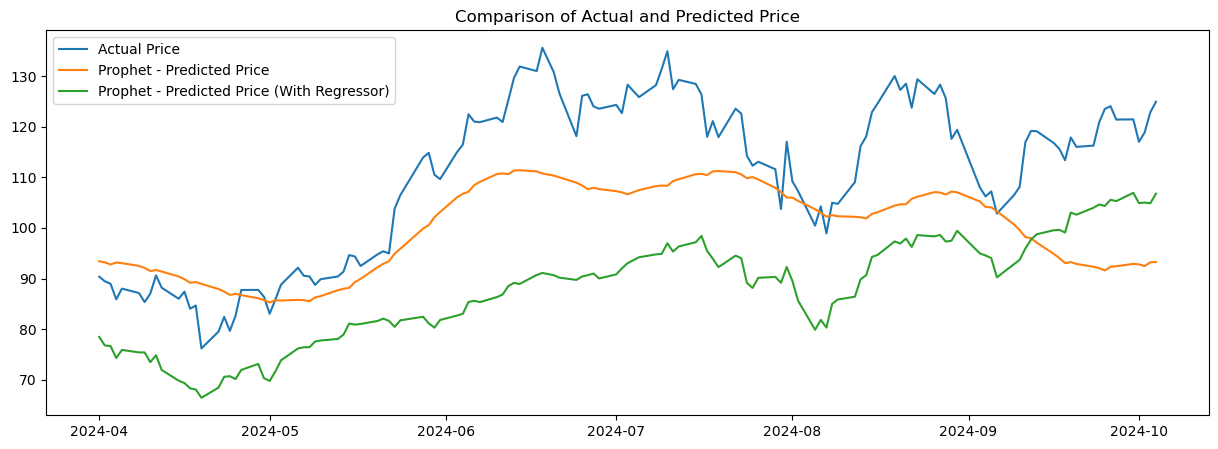

In [ ]:
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')


## Model Inference

In this step i will try to predict the the NVIDIA stock price from 2024-10-13 to 2024-10-06
1. Retrive nvidia and gspc stock data from yahoo finance
2. Preprocess until normalization and extract the date as a future variable (which will we use as a predicted variable)
3. Compare the predict result with the actual stock nvidia price in range2024-10-13 to 2024-10-06

### Extract Stock Price from Yahoo Finance

In [ ]:
def get_stock_data(ticker_code, start_date, end_date):
    return yf.download(ticker_code, start=start_date, end=end_date).reset_index()

def preprocess_data(ticker_code, start_date, end_date):
    df = get_stock_data(ticker_code, start_date, end_date)
    df = early_preprocess_dataset(df)
    df = preprocess_dataset(df)
    return df

# Tentukan tanggal dan kode saham
start_date = '2024-10-06'
end_date = '2024-10-14'

# Proses data untuk NVDA dan GSPC
df_nvda_inference = preprocess_data('NVDA', start_date, end_date)
df_gspc_inference = preprocess_data('^GSPC', start_date, end_date)

# Gabungkan DataFrame
df_inference = pd.merge(df_nvda_inference, df_gspc_inference, on='ds', how='left', suffixes=('', '_gspc'))

# Normalisasi Data
# df_inference_scaled = df_inference[['ds']].copy()
# df_inference_scaled[['y','y_gspc']] = scaler.transform(df_inference[['y', 'y_gspc']])

# Buat variable future untuk store ds and gspc
future_inference = df_inference[['ds','y_gspc']].copy()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


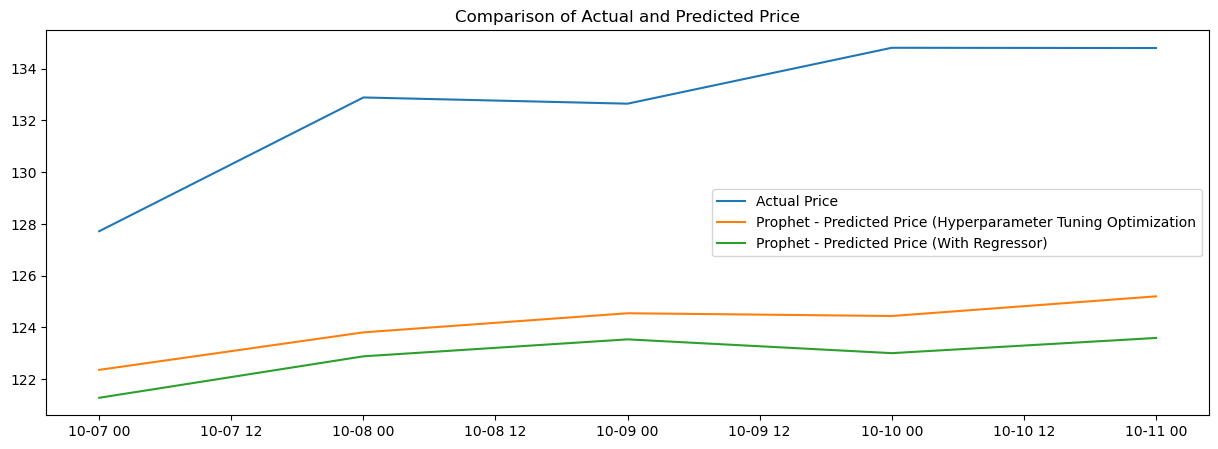

RMSE Score: 8.68
RMSE Score: 9.89


In [ ]:
df_predicted_inference = m_opt.predict(future_inference)
df_predicted_inference_v2 = prophet_model_regressor.predict(future_inference)
plt.figure(figsize=(15,5))
plt.plot(df_inference['ds'], df_inference['y'], label = 'Actual Price')
plt.plot(df_predicted_inference['ds'],df_predicted_inference['yhat'], label = 'Prophet - Predicted Price (Hyperparameter Tuning Optimization')
plt.plot(df_predicted_inference_v2['ds'],df_predicted_inference_v2['yhat'], label = 'Prophet - Predicted Price (With Regressor)')
plt.title('Comparison of Actual and Predicted Price')
plt.legend()
plt.show()

rmse_inference = root_mean_squared_error(df_inference['y'], df_predicted_inference['yhat'])
rmse_inference_v2 = root_mean_squared_error(df_inference['y'], df_predicted_inference_v2['yhat'])
print(f'RMSE Score: {rmse_inference:.2f}')
print(f'RMSE Score: {rmse_inference_v2:.2f}')


In [ ]:
df_inference

,ds,y,y_gspc
0,2024-10-07,127.720001,5695.939941
1,2024-10-08,132.889999,5751.129883
2,2024-10-09,132.649994,5792.040039
3,2024-10-10,134.809998,5780.049805
4,2024-10-11,134.800003,5815.029785


In [ ]:
df_predicted_inference[['ds','yhat']]

,ds,yhat
0,2024-10-07,122.362494
1,2024-10-08,123.811501
2,2024-10-09,124.550361
3,2024-10-10,124.443787
4,2024-10-11,125.203176


In [ ]:
(df_predicted_inference['yhat']- df_inference['y']).sum()/len(df_inference)

-8.49973518838595

In [ ]:
yhat_scaled = df_predicted_inference['yhat'].values.reshape(-1, 1)
# Create an array for inverse transformation with both columns
predicted_data = pd.DataFrame({
    'y': yhat_scaled.flatten(),         # Flattening to match original shape
    'y_gspc': future_inference['y_gspc']          # Include original scaled values for 'y_gspc'
})

# Inverse transform to get the original scale
original_values = scaler.inverse_transform(predicted_data)

# Extract the original yhat
yhat_original_scale = original_values[:, 0]  # First column is 'y'

# Add the original scale predictions to the DataFrame
df_predicted_inference['yhat_original'] = yhat_original_scale


In [ ]:
df_inference

,ds,y,y_gspc
0,2024-10-07,127.720001,5695.939941
1,2024-10-08,132.889999,5751.129883
2,2024-10-09,132.649994,5792.040039
3,2024-10-10,134.809998,5780.049805
4,2024-10-11,134.800003,5815.029785


130.33462707536543


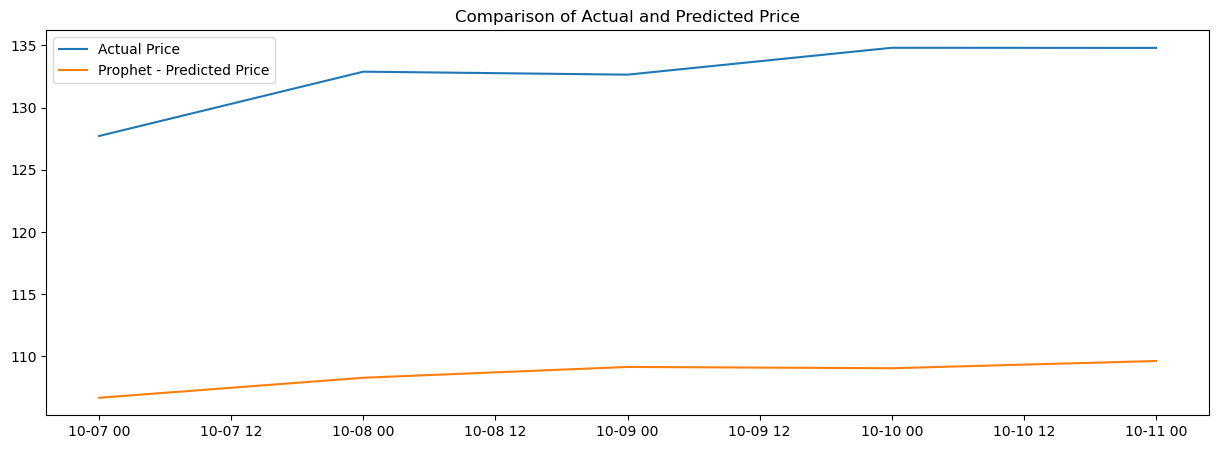

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(df_inference['ds'], df_inference['y'], label = 'Actual Price')
plt.plot(df_predicted_inference['ds'],df_predicted_inference['yhat_original'], label = 'Prophet - Predicted Price')
plt.title('Comparison of Actual and Predicted Price')
plt.legend()
rmse = root_mean_squared_error(df_inference['y'], df_predicted_inference['yhat'])
print(rmse)

In [ ]:
json_path = '../notebooks/best_params.json'
with open(json_path, 'r') as f:
    params = json.load(f)

In [ ]:
params

{'changepoint_prior_scale': 0.1,
 'seasonality_prior_scale': 10.0,
 'seasonality_mode': 'multiplicative',
 'holidays_prior_scale': 10,
 'interval_width': 0.8,
 'yearly_seasonality': True,
 'weekly_seasonality': True,
 'daily_seasonality': False}

In [ ]:
def load_preprocessed_dataset():
    try:
        train = pd.read_csv('../data/processed/df_train.csv')
        test = pd.read_csv('../data/processed/df_test.csv')
        # logging.info('Data Loaded Successfully')
        return train, test
    except Exception as e:
        # logging.info(f'Error Loading Data: {e}')
        print('Error')
df_train, df_test = load_preprocessed_dataset()

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      192 non-null    object 
 1   y       192 non-null    float64
 2   y_gspc  192 non-null    float64
dtypes: float64(2), object(1)
memory usage: 4.6+ KB


In [ ]:
from mlflow.models.signature import infer_signature
def train_model(df_train_scaled, df_test_scaled):
    try:
        json_path = '../notebooks/best_params.json'
        with open(json_path, 'r') as f:
            params = json.load(f)
        # prophet_model = Prophet(seasonality_mode='multiplicative').add_regressor('y_gspc')
        prophet_model = Prophet(**params).add_regressor('y_gspc')
        future = df_test_scaled[['ds']].copy()
        future['y_gspc'] = df_test_scaled['y_gspc']
        prophet_model.fit(df_train_scaled)
        df_predicted = prophet_model.predict(future)[['ds','yhat']]
        signature = infer_signature(df_test_scaled, df_predicted)
        rmse = root_mean_squared_error(df_predicted['yhat'], df_test_scaled['y'])
        # logging.info('Model Trained Successfully')
        return prophet_model, signature,df_predicted, rmse
    except Exception as e:
        # logging.info(f'Error Training Model: {e}')
        print('error')

In [ ]:
prophet_model, signature, df_predicted,rmse_score = train_model(df_train_scaled, df_test_scaled)

12:31:54 - cmdstanpy - INFO - Chain [1] start processing
12:31:55 - cmdstanpy - INFO - Chain [1] done processing


TypeError: tz must be string or tzinfo subclass, not <matplotlib.category.UnitData object at 0x000002A16CA509E0>.

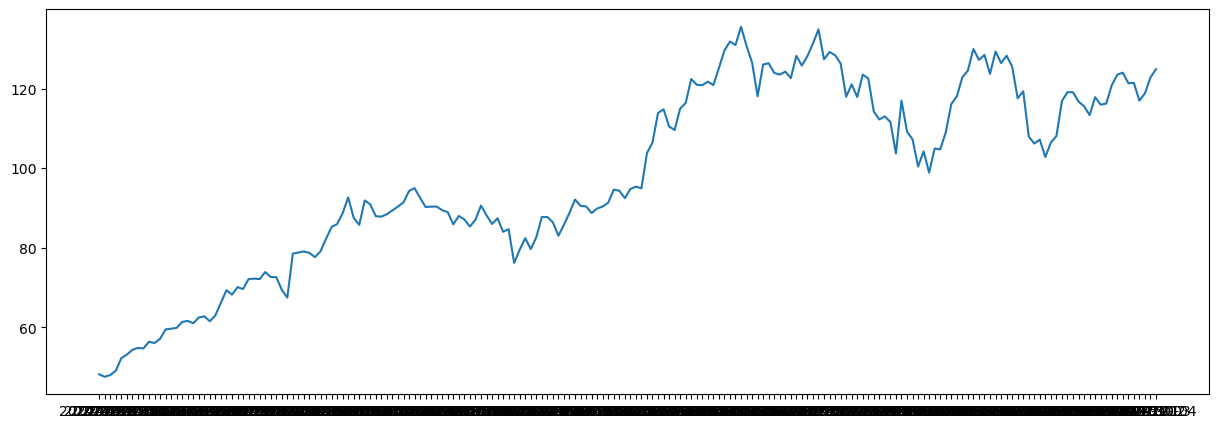

In [ ]:
def plot_model (df_test, df_predicted):
    plt.figure(figsize=(15,5))
    plt.plot(df_test['ds'], df_test['y'], label = 'Actual Price')
    plt.plot(df_predicted['ds'],df_predicted['yhat'], label = 'Prophet - Predicted Price')
    plt.title('Comparison of Actual and Predicted Price')
    plt.legend()
    plt.show()
    # plt.savefig('../visualizations/Comparison of Actual and Predicted Price.png')

plot_model(df_test, df_predicted)

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      192 non-null    object 
 1   y       192 non-null    float64
 2   y_gspc  192 non-null    float64
dtypes: float64(2), object(1)
memory usage: 4.6+ KB


In [ ]:
df_predicted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      131 non-null    datetime64[ns]
 1   yhat    131 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.2 KB
